# Biharmonic Equation solving 

## 1.Introduction

This report focuses on the modeling of a steel beam using the finite difference method and explores the behavior of the beam under various boundary conditions. In addition to studying the steady-state biharmonic equation, we also consider the non-stationary or time-dependent version of the biharmonic equation. This comprehensive analysis allows us to gain insights into the dynamic response of the beam and understand the significance of different boundary conditions, particularly in relation to moments and displacements.

The biharmonic equation, as mentioned earlier, describes the bending behavior of thin plates or beams. In its non-stationary form, the biharmonic equation can be expressed as:

$$
\frac{\partial^4u}{\partial x ^4} = \frac{1}{EI} \frac{\partial^2 u}{\partial t^2} + S           
$$

where u(x, t) represents the displacement of the beam at position x and time, E is the elastic modulus and I is the second moment of area of the beam's cross section. 
I must be calculated with respect to the axis which is perpendicular to the applied loading. This equation accounts for both spatial and temporal variations in the beam's bending behavior.

In this equation, the term "EI" combines the bending stiffness properties of the material and the geometric properties of the system. It is often used in the context of mechanics and structural engineering. This equation is typical when describing the behavior of beams or plates under bending. 
In this report, I will solve the biharmonic equation for a steel beam of 7 cm of diameter, so $ E \space = \space 1.9 \times 10^7 \space N.m^{-2} $ and $I = 117.8 \space cm^2$



In our case, we are interested in the stationary or time-independent solution of the biharmonic equation. This implies that the deflection does not change with time, and the equation simplifies to a static problem. 

$$
\frac{\partial^4u}{\partial x ^4} = 0
$$

We seek to solve this equation numerically using the finite difference method, which discretises the domain into dx intervals. The boundary conditions specify the vibrations and the bendong moments at the ends of the beam. In this example, the beam is blocked at the ends so the boundarys are all 0. 

The bending moments at x=0 and x=L are :

$$
\frac{\partial^2u(x)}{\partial x ^2} = 0 
$$

The exterieur forces at x=0 and x=L are :

$$
u(x) = 0
$$

By solving the Biharmonic equation with these boundary conditions, we can determine the profile along the copper beam.


In [3]:
using BoundaryValueDiffEq
using Plots
using SparseArrays
using LinearAlgebra
using BenchmarkTools

## 2.Source Fonction 


In this part, I model a single force acting on the beam. To do this, I will create a function that takes the form of a Gaussian function with a maximum value A representing the magnitude of the force, a width represented by the parameter σ, and located at position X0 on the beam.


$$ f(x) = A\exp{(-\frac{(x-x_0)^2}{\sigma^2})} $$

For the Biharmonic equation, this force is actually a constraint peak of magnitude A, width σ and located at position X0 on the beam. In this example, the constraint peak is located 100 cm along the beam with the maximum of force from a hammer hit with 200 N. 




In [261]:
function source_function(x)
    X0 = 100.0
    σ = 0.8
    A = 200.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

source_function (generic function with 1 method)

In [262]:
function source(N)
#Parameter
    l = 200.
    dx = l/N
#Mesh
    X_vect = Vector(0:dx:l)
# Function source
    f = source_function.(X_vect)
    return f
end

source (generic function with 1 method)

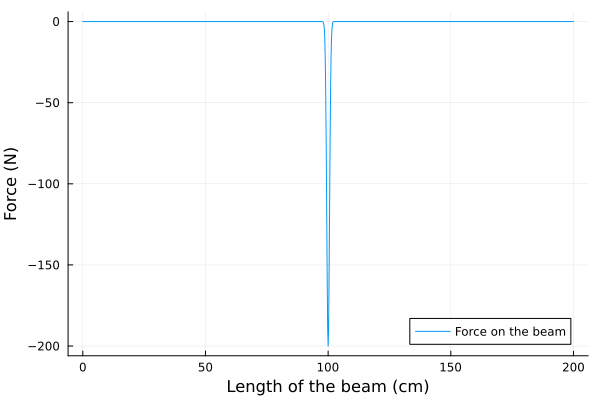

In [263]:
N = 1000
l = 200.
dx = l/N
plot(Vector(0:dx:l),source(N), label = "Force on the beam", ylabel = "Force (N)", xlabel = "Length of the beam (cm)" )

## 3.Finite difference modelling.


The 1D time-independent Biharmonic equation is a mathematical model used to describe the distribution of constraints in a one-dimensional medium over time.

$$ EI \times \frac{\partial^4{w}}{\partial{x}^4} = 0 + S(x) \space\space\space\space\space\space\space\space\space\space [1] $$ 
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences. For i $\epsilon$ $[3,N-1]$
$$
    \frac{\alpha(W_{i+2} -4W_{i+1} + 6W{i} - 4W_{i-1} + W_{i-2})}{dx^4} = 0 + S_i 
$$
With the boudarys conditions :

$$
   W|_{x=0} = U_1 = 0 
$$
$$
    \frac{\partial  W}{\partial x }|{x=0} = \frac{U_2 - U_1}{dx} = 0
$$
$$
    \frac{\partial  W}{\partial x}|_{x=L} = \frac{U_{N+1} - U_{N}}{dx} = 0
$$
$$
   W|_{x=L} = U_{N+1} = 0
$$
This leads to a system of linear equations Au = b, where A is a tridiagonal matrix that represents the coefficients of the finite difference scheme, x is the vector containing the unknown temperature values at each discretized point. With $\alpha = \frac{EI}{dx^4} $
$$
A = \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
\frac{-1}{dx} & \frac{1}{dx} & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
\alpha  & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 &\dots & \dots & 0 \\
0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 \\
 0 & \dots  & \dots  & 0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha \\
0&\dots & \dots & \dots & \dots & \dots & 0 & \frac{-1}{dx} & \frac{1}{dx} \\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

The vector b is is containing the known boundary conditions, so for this example the vector will be : 
$$
    \mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ 0\end{bmatrix}
$$
There are 4 boundary conditions, $B_1$,$B_2$ for conditions at x=0 and $B_N$,$B_{N+1}$ for conditions at x=L. These boundary conditions can be translated by the deflection (1), slope (2) and force (3) applied to the beam and can be defined by :

$$ 
    (1) : W|_{x=x_i} = U_i
$$
$$
    (2) : \frac{\partial W}{\partial x }|_{x_i} = \frac{U_i - U_{i-1}}{dx}
$$
$$
    (3) : \frac{\partial ^2 W}{\partial x^2}|_{x_i} = \frac{U_{i+1}-2U_i + U_{i-1}}{dx^2}
$$

The constraint source must be added to the linear system to get the real case. 

$$
    \mathbf{S} = \begin{bmatrix} f(0) \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ f(L)\end{bmatrix}
$$

So the linear system that we trying to solve is :

$$
   \fbox{ Au = b+S}
$$

Firstly, we will create the matrix A with the data used for a copper beam. We'll use E the young module in Pa and the second moment of the area I and must be calculated with respect to the axis which is perpendicular to the applied loading. The beam is fixed at the ends. 


In [264]:
function matrix(n)
#Parameter
    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8
    α = E * I / dx^4

    

# Build the matrix
    A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )

# Coefficient that change in the  matrix 
    A[1,2] = 0.
    A[1,1]= 1.
    A[1,3] = 0.

    A[2,1] = -1/dx
    A[2,2] = 1/dx
    A[2,3] = 0.
    A[2,4] = 0.

    A[n-1, n-3] = 0.
    A[n-1,n-2] = 0.
    A[n-1,n-1] =-1/dx
    A[n-1,n] = 1/dx
    
    A[n,n-2] = 0.
    A[n,n-1] = 0.
    A[n,n]= 1.

#time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

matrix (generic function with 1 method)

In [265]:
function biharmonic(N)
    #Parameter of the beam
        l= 200.0 #length
        dx = l/ N  

    # Build of the matrix A
        A = matrix(N+1)

    # Vector B from Au = B (Boundary)
        b = zeros(N+1)
        b[1] = 0.                            #Deflection at x=0
        b[2] = 0.                            #Slope at x = 0
        b[end-1] = 0.                        #Slope at x = L
        b[end] = 0.                          #Deflection at x = L

    # Vector S for the source power
        X_vect = Vector(0:dx:l)
        S = source_function.(X_vect) 

    # Solving of the Linear System
        u = A \ (b+S) 
        return u
end

biharmonic (generic function with 1 method)

We also need to test the calculation time for this resolution. We can see that for a 1000x1000 matrix, the resolution time is fairly short.

In [266]:
@btime biharmonic(100)

  85.862 μs (139 allocations: 189.25 KiB)


101-element Vector{Float64}:
  0.0
  0.0
 -1.672497235130845e-5
 -4.948529818048966e-5
 -9.759135861410798e-5
 -0.00016035353477872774
 -0.00023708220780091336
 -0.00032708775880722923
 -0.0004296805689242399
 -0.0005441710192785101
  ⋮
 -0.000429680568925797
 -0.0003270877588084152
 -0.0002370822078017735
 -0.00016035353477930993
 -9.759135861446256e-5
 -4.9485298180669586e-5
 -1.67249723513693e-5
 -0.0
  0.0

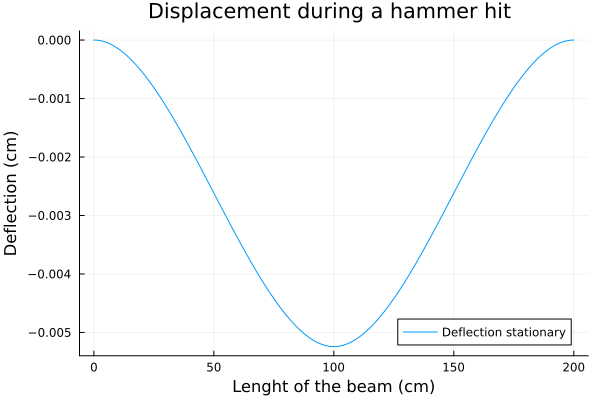

In [267]:
title = "Displacement during a hammer hit "
X = Vector(0:dx:l)
U = biharmonic(N)
plot(X, U[:,1], label = "Deflection stationary", xlabel = "Lenght of the beam (cm)", ylabel = "Deflection (cm)", title = title)


## 4.Using BoundaryValueDiffEq from julia


The function is intended for ordinary differential equations ( thus  no partial differentials equations , thus only x). Boundary value problems (thus no initial values problems) The BoundaryValueDiffEq package provides a comprehensive set of tools for solving BVPs, including a wide range of solvers and utilities.

To use BoundaryValueDiffEq, we define our BVP by specifying the differential equation, boundary conditions, and the domain or spatial range. The differential equation is typically defined as a function that calculates the derivatives of the dependent variables with respect to the independent variable x. The boundary conditions define the values or relationships at the boundaries of the domain.

Once the BVP is defined, we create a BVProblem object, which encapsulates the differential equation, boundary conditions, and domain information. We can then use the solve() function to solve the BVP and obtain the solution.

BoundaryValueDiffEq supports various numerical methods for solving BVPs, including shooting methods, finite difference methods, and collocation methods. The choice of solver depends on the specific problem characteristics and requirements.

I will divide the programme into three parts : 

The first of which will explain the problem of diffusion. The problem can be explained in the same way as the Biharmonic equation with the equation [1]. Moroover each derivative presents a physical phenomenon:

   $$ \frac{\partial{u}}{\partial{x}} = U_2   \space\space\space\space\space\space\space\space\space\space Slope $$

   $$ \frac{\partial^2{u}}{\partial{x}^2} = U_3 \space\space\space\space\space\space\space\space\space\space Bending \space Moment $$  

   $$ \frac{\partial^3{u}}{\partial{x}^3} = U_4 \space\space\space\space\space\space\space\space\space\space Force $$ 



The second part is the boundarys are explicited. Indeed, there are two boudarys conditions.


$$
    W|_{x=0} = W_1 = 0
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = \frac{W_2 - W_1}{dx} = 0 \Rightarrow W_1 = W_2 = 0
$$
$$
    \frac{\partial W}{\partial x}|_{x=L} = \frac{W_{N+1} - W_N}{dx} = 0 \Rightarrow W_{N+1} = W_{N} = 0
$$
$$
    W|_{x=L} = W_{N+1} = 0
$$

   
   


The last part is the resolution of the diffusion function and the boundarys function. As before, the parameters are those of an 80cm copper beam. With this programme, my result (sol1) is an N x 2 matrix, but to plot the solution, I only need the first term of each line. So I create a loop to obtain the solution vector sol2.



In [268]:
# define diffusion equation 
function diffusion!(du, u, p, x)

    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0. + (1/p[1]) * source_function(x)
    
end

diffusion! (generic function with 1 method)

In [269]:
# define boundary conditions 
function boundaries!(residual, u, p, x)
    f = source(N)

    # residual boundary condition in the left end-point 
    residual[1] = u[1][1] - 0.                                              #Deflection at x=0 : U1 = 0
    residual[2] = u[2][1] - 0.                                              #Slope at x=0 : U2 -U1 = 0 so U1=U2
    # residual boundary condition in the right end-point 
    residual[end-1] = u[end-1][1]  - 0                                      #Slope at x=L : U_n+1 -U_n = 0 so U_n+1 = U_n
    residual[end] = u[end][1] - 0                                           #Dflection at x=0
end

boundaries! (generic function with 1 method)

In [270]:
function set_boundarys(N)  
# define spatial range 
    xspan = (0.0, 200.0)
    l = 200.0
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8
    p = [E*I]; 
    
#set the boundary value problem to solve
bvp1 = BVProblem(diffusion!, boundaries!, [0., 0.,0.,0.], xspan,p)

# set the boundary value problem  
sol1 = solve(bvp1, GeneralMIRK4(), dt = dx)
sol2 = zeros(length(sol1))

for i in 1:length(sol1)
    sol2[i] = sol1[i][1]  
end
return sol2
    
end



set_boundarys (generic function with 1 method)

We also need to test the calculation time for this resolution. We can see that for a 100 points, the resolution time is long(60 sec). So it is important to note that the finite difference mode is shorter.

In [271]:
@btime set_boundarys(100)

  187.599 ms (3581550 allocations: 309.13 MiB)


101-element Vector{Float64}:
  0.0
  0.0
 -1.0645050359650646e-5
 -3.1496153174326106e-5
 -6.211431053940056e-5
 -0.00010206052455024818
 -0.00015089579730224315
 -0.00020818113089075962
 -0.0002734775274111718
 -0.0003463459889588539
  ⋮
 -0.0002734775274111722
 -0.00020818113089075997
 -0.00015089579730224342
 -0.00010206052455024838
 -6.21143105394007e-5
 -3.149615317432618e-5
 -1.064505035965067e-5
  0.0
  0.0

## 5.Comparison 

The plots of the two methods are identical, and it can be seen that the source interferes with the solution of the Biharmonic equation, which is normal. However, using the finite difference method to solve the Biharmonic equation is better because of the reduced calculation time.
Moreover, the relative error between these two methods is around $8.10^{-3}$ maximum, which is another good point for the finite difference method.

In [272]:
N = 200
l= 200.0
dx = l/N

1.0

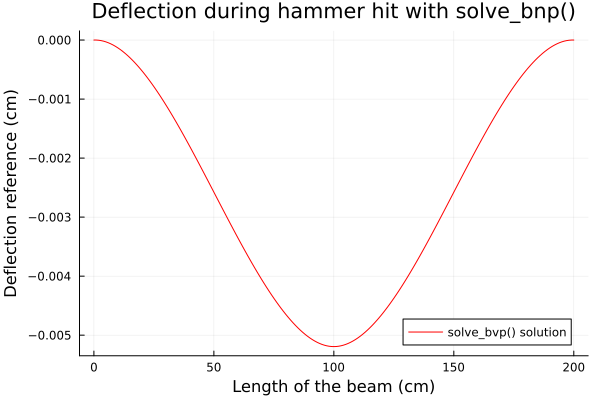

In [273]:

xvec = Vector(0:dx:l)
fvec = source_function.(xvec)
plot(xvec, set_boundarys(N), label = "solve_bvp() solution", xlabel = "Length of the beam (cm)", ylabel = "Deflection reference (cm)", linecolor = :red, title = "Deflection during hammer hit with solve_bnp()")


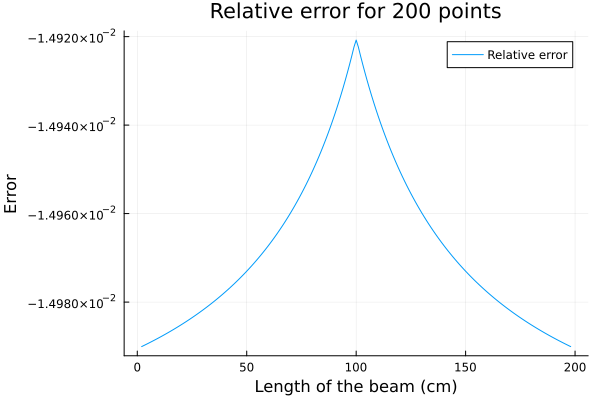

In [274]:

exact = set_boundarys(N)
modele = biharmonic(N)
error = (abs.(exact .- modele) ./ exact) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam (cm)", ylabel = "Error", title = title)


A relative error is a measure used to quantify the accuracy of an approximation or calculation compared to the true or exact value of a quantity. It is a way to express how much the calculated value deviates from the true value as a percentage or proportion of the true value.

The formula to calculate the relative error is as follows:

$$
    Relative Error = \frac{|(Reference Value - Approximated Value)|}{|Reference Value|}
$$

The result of the calculation will be a non-negative number, representing the proportion of the difference between the true value and the approximated value compared to the magnitude of the true value. The relative error is typically expressed as a percentage by multiplying it by 100.

## 6) Physical examples 

### A. Beam embedded on the left and with a point force on the right. 

An important class of problems concerns cantilever beams. The bending moments (M), shear forces (F) and deflections (W) for a cantilever beam subjected to a point load at the free end and a uniformly distributed load are given in the table below. In this situation, the first derivative is the deflection of the beam, the second derivative is the slope of the deflection, the third derivative is for the bending moment and the fourth derivative is for the forces.

For this first example, I need to find 4 boundarys conditions indeed there is a force at the end of the beam and an encastrement at the beginning of it. 
$$ \frac{\partial^4{W}}{\partial{x}^4} = 0$$

$$
    W|_{x=0} = 0
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
    W|_{x=L} =A
$$

I need to compare the finite difference and the solve.bp() method but the calculation time with the second method is too long so I will use dx = 1.

#### A.1) Finite difference modeling 

The matrix boundarys of the matrix A will change with my boundarys conditions. Indeed, the matrix A was : 
$$
A = \frac{EI}{dx^4} \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
0 & 1 & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
1 & -4 & 6 & -4 & 1 & 0 &\dots & \dots & 0 \\
0 & 1 & -4 & 6 & -4 & 1 & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & 1 & -4 & 6 & -4 & 1 & 0 \\
 0 & \dots  & \dots  & 0 & 1 & -4 & 6 & -4 & 1 \\
0&\dots & \dots & \dots & \dots & \dots & 0 & 1 & 0 \\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

I have to change the second and The penultimate lines of the matrix to fit the boundarys conditions. For this I discritized  for i in [1,N+1] points  : 
$$
    W|_{x=0} = W_1 = 0
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = \frac{W_1 - W_0}{dx} = 0 \Rightarrow W_1 = W_2 = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = \frac{W_N - 2W_{N-1} + W_{N-2}}{dx^2} = 0
$$
$$
    W|_{x=L} = W_{N+1} =  \space \frac{Fx^2(3l - x)}{6EI} \space with \space x = l
$$

So, the matrix became : With $\alpha = \frac{EI}{dx^4} $
$$
A = \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
\frac{-1}{dx} & \frac{1}{dx} & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
\alpha  & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 &\dots & \dots & 0 \\
0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 \\
 0 & \dots  & \dots  & 0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha \\
0&\dots & \dots & \dots & \dots & \dots & \frac{1}{dx^2} & \frac{-2}{dx^2} & \frac{1}{dx^2} \\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$


In [275]:
function source_function_1(x)
    
    X0 = 200.0
    σ = 0.8
    A = 200.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

source_function_1 (generic function with 1 method)

In [276]:
function matrix_Deflection_1(n)
    #Parameter
        l = 200.0#length 
        dx = 1
        E = 1.9 * 10^7
        I = 117.8
     
        α = E * I / dx^4
    
           
    
    # Build the matrix
        A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )
    
    # Coefficient that change in the  matrix (TRIED SOMETHING THAT WORK BETTER)
        A[1,2] = 1
        A[1,1]= 1
        A[1,3] = 0

        A[2,1] = -1 / (dx^1)
        A[2,2] = 1 / (dx^1)

        A[2,3] = 0
        A[2,4] = 0
        A[n-1, n-3] = 0


        A[n-1,n-2] = 1 / (dx^2)
        A[n-1,n-1] = -2 / (dx^2)
        A[n-1,n] = 1 / (dx^2)


        A[n,n-2] = 0
        A[n,n-1] = 0
        A[n,n]= 1
    
    #time 135.690 microseconds and 65 allocations for n= 2000
        return A
    end

matrix_Deflection_1 (generic function with 1 method)

In [277]:
function matrix_Bending_1(n)

    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8
    α = E * I / dx^2

    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 

    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
    
end

matrix_Bending_1 (generic function with 1 method)

In [278]:
function biharmonic_1(N)
    #Parameter of the beam
        l= 200.0 #length
        dx = 1
        E = 1.9 * 10^7
        I = 117.8
    
        
  

    # Build of the matrix A for deflection and M for Bending moment 
        A = matrix_Deflection_1(N+1)
        M = matrix_Bending_1(N)

    # Vector B for boundarys deflection and B2 for boundarys bending moment
        b = zeros(N+1)
        b[1] = 0.      
        b[2] = 0.    
        b[end-1] = 0. 
        b[end] =   (source_function_1(l) * (l^3) * 2 )/ (6 * (E * I))       
        
        b2 = zeros(N+1)
        b2[1] = 200*l
        b2[end] = 0

    # Vector S for the source power
    
        X_vect = Vector(0:dx:l)
        

    # Solving of the Linear Systems
        
       u = A \ b
       m = M \ b2
        
        return [u,m]
end

biharmonic_1 (generic function with 1 method)

In [279]:
@btime biharmonic_1(10000)

  16.078 ms (312 allocations: 28.49 MiB)


2-element Vector{Vector{Float64}}:
 [0.0, 0.0, -7.145885487797488e-9, -2.1436942590813475e-8, -4.2872457436468976e-8, -7.145171615218502e-8, -1.071740048653826e-7, -1.500386097034827e-7, -2.000448167939063e-7, -2.5719191226407437e-7  …  -0.23796496729425906, -0.23800071741422058, -0.2380364675391869, -0.23807221766844308, -0.2381079678012741, -0.238143717936965, -0.23817946807480084, -0.23821521821406658, -0.23825096835404724, -0.23828671849402794]
 [40000.0, 39995.99997619958, 39991.999952406295, 39987.99992862016, 39983.999904841156, 39979.99988106929, 39975.99985730457, 39971.99983354698, 39967.99980979653, 39963.99978605321  …  35.99989288014574, 31.999904782335577, 27.999916684531133, 23.999928586731688, 19.999940488936527, 15.999952391144939, 11.999964293356205, 7.999976195569613, 3.9999880977844495, 0.0]

For 10000 points the calculation time is only 8 ms. So the scheme is working well. 

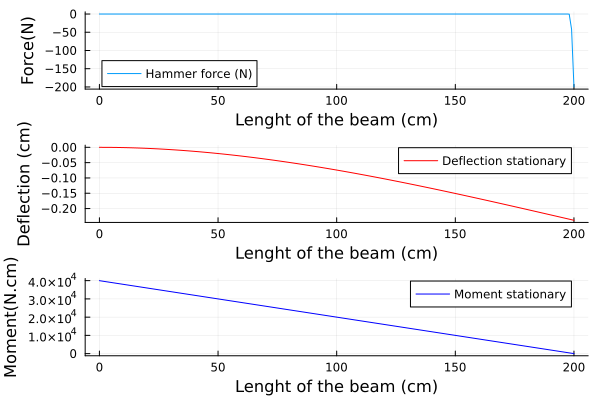

In [280]:

N = 200
dx = 1
X = Vector(0:dx:l)
U = biharmonic_1(N)

p1 = plot(X, source_function_1.(X), label = "Hammer force (N)", xlabel = "Lenght of the beam (cm)", ylabel = "Force(N)" )
p2 = plot(X, biharmonic_1(N)[1], label = "Deflection stationary", xlabel = "Lenght of the beam (cm)", ylabel = "Deflection (cm)" , linecolor = :red)
p3 = plot(X, biharmonic_1(N)[2], label = "Moment stationary", xlabel = "Lenght of the beam (cm)", ylabel = "Moment(N.cm)" , linecolor = :blue)

plot(p1,p2,p3,layout=(3,1))


#### A.2) BoundaryValueDiffEq Pkg

I will use the Biharmonic equation with no source then add a force at the end of the beam with the function boudaries_example_1!

In [281]:
# define diffusion equation 
function diffusion_example_1!(du, u, p, x)

    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0. 
end

diffusion_example_1! (generic function with 1 method)

In [282]:
# define boundary conditions 
function boundaries_example_1!(residual, u, p, x)
    l = 200.

    residual[1] = u[1][1]                                                                        # Deflection at the beginning 
    residual[2] = u[2][1]                                                            # Slope at the beginning : W2 = W1 = 0
    residual[end-1] = u[end][3]                                                                  # Bending Moment at the end 
    residual[end] = u[end][1]  + 200 * (l^3) / (3 * p[1])                                        # Force at the end 
 
end

boundaries_example_1! (generic function with 1 method)

In [283]:
function set_boundarys_example_1(N)  
# define spatial range 
    xspan = (0.0, 200.)
    l = 200.
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8
    p = [E*I]; 

#set the boundary value problem to solve
    bvp1 = BVProblem(diffusion_example_1!, boundaries_example_1!, [0., 0.,200.,200.], xspan,p)

# set the boundary value problem  
    sol1 = solve(bvp1, GeneralMIRK4(), dt = dx)
    sol_deflection = zeros(length(sol1))
    sol_moment = zeros(length(sol1))

    for i in 1:length(sol1)
        sol_deflection[i] = sol1[i][1]  
        sol_moment[i] = sol1[i][3]
    end
    return  [ - sol_moment , sol_deflection] # Deflection centimenter 
    
end

set_boundarys_example_1 (generic function with 1 method)

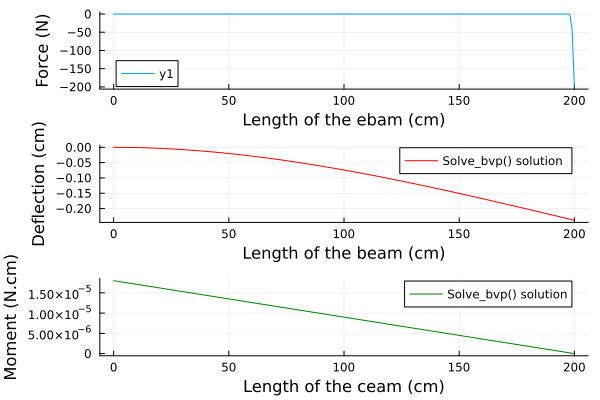

In [284]:
l = 200
xvec = Vector(0:dx:l)
X0 = 200.0
σ = 0.8
A = 200.
p1 = plot(xvec,- A .* exp.(.-((xvec .- X0).^2)./σ^2))
xlabel!("Length of the ebam (cm)") 
ylabel!("Force (N)")

p2 = plot(xvec, set_boundarys_example_1(N)[2], label = "Solve_bvp() solution ", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, set_boundarys_example_1(N)[1], label = "Solve_bvp() solution", xlabel = "Length of the ceam (cm)", ylabel = "Moment (N.cm)", linecolor = :green)


plot(p1,p2,p3,layout=(3,1))

Impossible to simulated at the same time the correct bending moment and deflection because for the first one, I need two conditions and for the deflection I need three conditions. But I have only  four conditions available. 

#### A.3)Comparison 

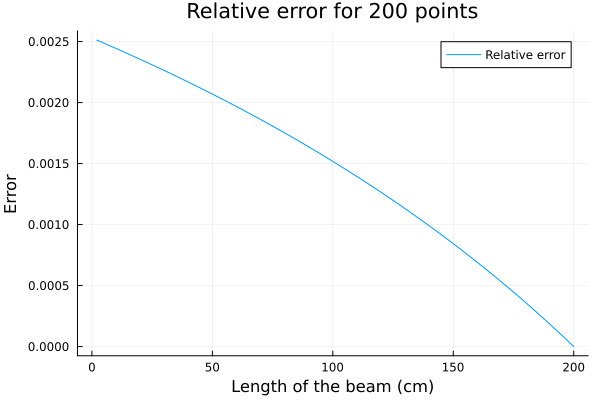

In [333]:
exact = set_boundarys_example_1(N)[2]
modele = biharmonic_1(N)[1]
error = abs.((abs.(exact .- modele) ./ exact)) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam (cm)", ylabel = "Error", title = title)

### B) Beam embedded on the left and with uniformly distributed load	

For this example,  the beam is subjected to a uniform force distribution along its length. This means that the force acts evenly across the entire span of the beam. The magnitude of this force is specified as 10 units. The direction of the force will depend on the coordinate system and the orientation of the beam.

The uniform force applied to the beam can cause it to undergo deformation and induce stresses within its material. By analyzing the beam's response, we can evaluate its deflection, bending moments, and other important characteristics.

To investigate the beam's behavior, we employ mathematical models, such as the biharmonic equation, which describes the bending of thin beams. This equation involves solving a linear system represented by a matrix equation, where the unknowns are the deflection values at discrete points along the beam's length.

The boundarys conditions are : 
 
$$ \frac{\partial^4{W}}{\partial{x}^4} = \frac{F}{EI} $$

$$
    W|_{x=0} = 0 
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
    \frac{\partial ^3 W}{\partial x^3}|_{x=L} = F
$$

#### B.1) Finite difference modeling 



The matrix boundarys of the matrix A will change with my boundarys conditions. Indeed, the matrix A was : 
$$
A = \frac{EI}{dx^4} \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
0 & 1 & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
1 & -4 & 6 & -4 & 1 & 0 &\dots & \dots & 0 \\
0 & 1 & -4 & 6 & -4 & 1 & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & 1 & -4 & 6 & -4 & 1 & 0 \\
 0 & \dots  & \dots  & 0 & 1 & -4 & 6 & -4 & 1 \\
0&\dots & \dots & \dots & \dots & \dots & 0 & 1 & 0 \\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

I have to change the second and the penultimate lines of the matrix to fit the boundarys conditions. For this I discritized  for i in [1,N+1] points  : 
$$
    W|_{x=0} = W_1= 0
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = \frac{W_2 - W_1}{dx} = 0 \Rightarrow W_2 = W_1 = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = \frac{W_{N+1} - 2W_{N} + W_{N-1}}{dx^2} = 0
$$
$$
   \frac{\partial  W}{\partial x}|_{x=L} = W_{N+1}= \frac{F l^2 (3l^2)}{24EI}
$$

So, the matrix became : With $\alpha = \frac{EI}{dx^4}$


$$
A =  \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
\frac{-1}{dx} & \frac{1}{dx} & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
\alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 &\dots & \dots & 0 \\
0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 \\
 0 & \dots  & \dots  & 0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  \\
 0&\dots & \dots & \dots & \dots  &  \dots & \frac{1}{dx^2} & \frac{-2}{dx^2} & \frac{1}{dx^2}\\
0&\dots & \dots & \dots & -\frac{0.5}{dx^3} & \frac{1}{dx^3} & 0 & \frac{-1}{dx^3} & \frac{0.5}{dx^3} \\

\end{bmatrix}



For this example, I imagined that a block of 10 kg was on the beam. So the force is $F \space = \space 9.81 * 100 \space = \space 98.1 N$.

In [286]:
N = 200

200

In [287]:
function source_function_2(x)
    A = 98.1
    return -A + 0*x
end

source_function_2 (generic function with 1 method)

In [288]:
function matrix_Deflection_2(n)
    #Parameter
    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8  
    α = E*I / dx^4

       

# Build the matrix
    A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )

# Coefficient that change in the  matrix 
    A[1,2] = 0
    A[1,1]= 1
    A[1,3] = 0

    A[2,1] = - 1 /dx
    A[2,2] =  1 /dx

    A[2,3] = 0
    A[2,4] = 0
    A[n-1, n-3] = 0


    A[n-1,n-2] = 1 /dx^2
    A[n-1,n-1] = -2 /dx^2
    A[n-1,n] = 1 /dx^2


    A[n,n-4] = 0.5 /dx^3
    A[n,n-3] = -1 /dx^3
    A[n,n-2] = 0 /dx^3
    A[n,n-1] = 1 /dx^3
    A[n,n]= - 0.5/dx^3

    #=A[n,n-4] = 0
    A[n,n-3] = 0
    A[n,n-2] = 0
    A[n,n-1] = 0
    A[n,n]= 1=#

 

#time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

matrix_Deflection_2 (generic function with 1 method)

In [289]:
function matrix_Bending_2(n)
    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8
    α = E * I / dx^2

    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 

    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
end

matrix_Bending_2 (generic function with 1 method)

In [290]:
function biharmonic_2(N)
#Parameter of the beam
    l= 200.0 #length
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8
    X_vect = Vector(0:dx:l)


# Build of the matrix A and M1
    A = matrix_Deflection_2(N+1)
    M1 = matrix_Bending_2(N)

# Vector B and b2
    b = zeros(N+1)
    b[1] = 0. 
    b[2] = 0.    
    b[end-1] = 0. 
    b[end] = 0

    b2 = zeros(N+1)
    b2[1] = 50 * l^2
    b2[end] = 0

# Vector S for the source power

    
    S = source_function_2.(X_vect) 
    S[end] = 0
    S[end-1] = 0
    S[2] = 0
    S[1] = 0
    

# Solving of the Linear System
    
    u = A \ (S+b)
    m = M1 \ (S+b2)
    
    
    return [u,m]
end

biharmonic_2 (generic function with 1 method)

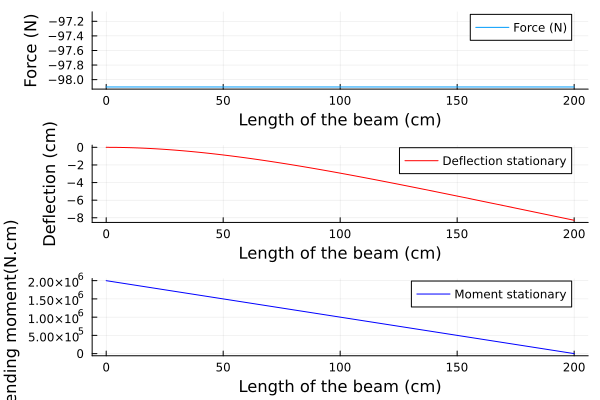

In [291]:


X = Vector(0:dx:200.0)
p1 = plot(xvec, source_function_2.(xvec), label = "Force (N)", xlabel = "Length of the beam (cm)" , ylabel = "Force (N)" )
p2 = plot(xvec, biharmonic_2(N)[1], label = "Deflection stationary", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, biharmonic_2(N)[2], label = "Moment stationary", xlabel = "Length of the beam (cm)", ylabel = "Bending moment(N.cm)", linecolor = :blue)

plot(p1, p2,p3,layout=(3,1))



#### B.2) BoundaryValueDiffEq Pkg

In [292]:
# define diffusion equation 
function diffusion_example_2!(du, u, p, x)
    
    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0. + source_function_2.(x) /p[1]

end

diffusion_example_2! (generic function with 1 method)

In [293]:
# define boundary conditions 
function boundaries_example_2!(residual, u, p, x)
                                                             
    residual[1] = u[1][1]                                               # Deflection at the beginning 
    residual[2] = u[2][1]                                               # Slope 
    residual[end-1] = u[end][3]                                         # Bending Moment at the end 
    residual[end] = u[end][4]               # Force at the end 

end


boundaries_example_2! (generic function with 1 method)

In [294]:
function set_boundarys_example_2(N)  

# define spatial range 
    l = 200.
    xspan = (0.0, 200.)
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8
    p = [E*I]; 

#set the boundary value problem to solve
    bvp1 = BVProblem(diffusion_example_2!, boundaries_example_2!, [0., 0.,200.,200.], xspan,p)

# set the boundary value problem  
    sol1 = solve(bvp1, GeneralMIRK4(), dt = dx,abstol=1e-8, reltol=1e-8)
    sol_deflection = zeros(length(sol1))
    sol_moment = zeros(length(sol1))

    for i in 1:length(sol1)
        sol_deflection[i] = sol1[i][1]  
        sol_moment[i] = sol1[i][3]
    end
    return  [ - sol_moment , sol_deflection]
    
end

set_boundarys_example_2 (generic function with 1 method)

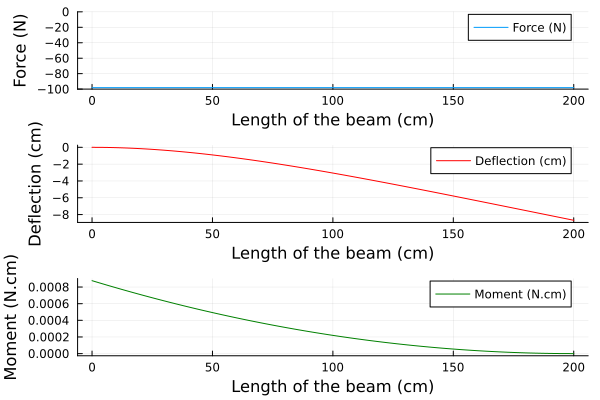

In [295]:

xvec = 0:dx:l
p1 = plot(xvec, source_function_2.(xvec), label = "Force (N)", xlabel = "Length of the beam (cm)", ylim = (-100,0), ylabel = "Force (N)" )
p2 = plot(xvec, set_boundarys_example_2(N)[2], label = "Deflection (cm)", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, set_boundarys_example_2(N)[1], label = "Moment (N.cm)", xlabel = "Length of the beam (cm)", ylabel = "Moment (N.cm)", linecolor = :green)

plot(p1,p2,p3,layout=(3,1)) 

Same problem here 

#### B.3) Comparison 

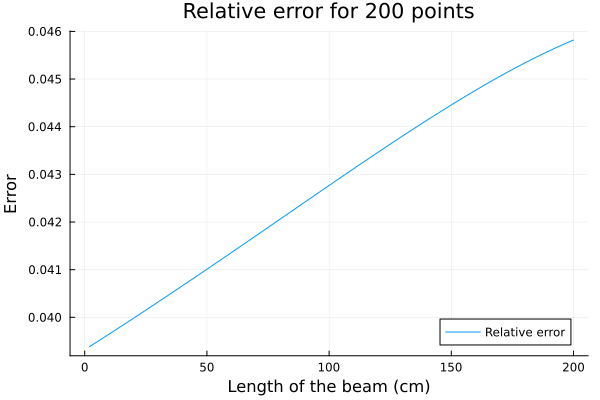

In [334]:
exact = set_boundarys_example_2(N)[2]
modele = biharmonic_2(N)[1]
error = abs.((abs.(exact .- modele) ./ exact)) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam (cm)", ylabel = "Error", title = title)

### C) Simply supported beam with central load

The three-point bending test is a classical experiment in mechanics. It represents the case of a beam resting on two roller supports and subjected to a concentrated load applied in the middle of the beam. The shear is constant in absolute value: it is half the central load, P / 2. It changes sign in the middle of the beam. The bending moment varies linearly from one end, where it is 0, and the center where its absolute value is PL / 4, is where the risk of rupture is the most important. The deformation of the beam is described by a polynomial of third degree over a half beam (the other half being symmetrical). The bending moments (M), shear forces (Q), and deflections (w) for a beam subjected to a central point load and an asymmetric point load are given in the table below.

For this  example, I need to find 4 boundarys conditions with F a point force on the beam execpt boundarys. 
$$ \frac{\partial^4{W}}{\partial{x}^4} = \frac{F}{EI} $$

$$
    W|_{x=0} = 0 
$$
$$
    \frac{\partial^2 W}{\partial x^2}|_{x=0} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
    W|_{x=L} = 0 
$$


I have to change the second and the penultimate lines of the matrix A again to fit the boundarys conditions. For this I discritized  for i in [1,N+1] points  : 
$$
    W_1 = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=0} = \frac{W_3 -2W_2 + W_1}{dx^2} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = \frac{W_{N+1}- 2W_{N} + W_{N-1}}{dx^2} = 0
$$
$$
    W_{N+1} = 0
$$

So, the matrix became : With $\alpha = \frac{EI}{dx^4}$


$$
A =  \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
\frac{1}{dx^2} & \frac{-2}{dx^2} & \frac{1}{dx^2}  & \dots & \dots & \dots & \dots & \dots & 0 \\
\alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 &\dots & \dots & 0 \\
0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 \\
 0 & \dots  & \dots  & 0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  \\
 0&\dots & \dots & \dots & \dots  &  0 & \frac{1}{dx^2} & \frac{-2}{dx^2} & \frac{1}{dx^2}\\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\

\end{bmatrix}
$$


#### C.1) Finite Difference modeling 

In [297]:
function matrix_deflection_3(n)
    #Parameter
        l = 200.#length 
        dx = l/n
        E = 1.9 * 10^7
        I = 117.8
        α = E * I / dx^4
    
        
    
    # Build the matrix
        A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )
    
    # Coefficient that change in the  matrix (TRIED SOMETHING THAT WORK BETTER)
        A[1,2] = 0
        A[1,1]= 1
        A[1,3] = 0
        A[2,1] = 1/dx^2
        A[2,2] = -2/dx^2
        A[2,3] = 1/dx^2
        A[2,4] = 0
        A[n-1, n-3] = 0
        A[n-1,n-2] = 1/dx^2
        A[n-1,n-1] = -2/dx^2
        A[n-1,n] = 1/dx^2
        A[n,n-2] = 0
        A[n,n-1] = 0
        A[n,n]= 1
    
    #time 135.690 microseconds and 65 allocations for n= 2000
        return A
    end

matrix_deflection_3 (generic function with 1 method)

In [298]:
function matrix_bending_3(n)

    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8
    α = E * I / dx^2

    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 

    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
    
end

matrix_bending_3 (generic function with 1 method)

In [299]:
function biharmonic_3(N)
    #Parameter of the beam
        l= 200 #length
        dx = l/ N  

    # Build of the matrix A and M1
        A = matrix_deflection_3(N+1)
        M1 = matrix_bending_3(N)

    # Vector B and b2
        b = zeros(N+1)
        b[1] = 0.                                   #Deflection at x = 0
        b[2] = 0.                                   #Bending Moement at x = 0
        b[end-1] = 0.                               #Bending Moment at x = L 
        b[end] = 0.                                 #Deflection at x = L
        
        b2 = zeros(N+1) 
        b2[1] = 0
        b2[end] = 0

    # Vector S for the source power
        X_vect = Vector(0:dx:l)
        S = source_function.(X_vect) 

    # Solving of the Linear System
        u = A \ (b+S) 
        m = M1 \ (b2+S)
        return [u,m]
       
end

biharmonic_3 (generic function with 1 method)

In [300]:
@btime biharmonic_3(1000)

  1.381 ms (279 allocations: 2.92 MiB)


2-element Vector{Vector{Float64}}:
 [0.0, -6.28454271289251e-5, -0.0001256908542578502, -0.00018853577659089753, -0.00025137968933218913, -0.00031422208768584704, -0.00037706246685599305, -0.000439900322046749, -0.0005027351484622365, -0.0005655664413065768  …  -0.0005655664560560782, -0.0005027351615739386, -0.0004399003335202642, -0.000377062476690989, -0.0003142220958820465, -0.0002513796958893705, -0.0001885357815088945, -0.00012569085753655186, -6.284542876827593e-5, 0.0]
 [0.0, -1.267053805015512e-8, -2.534107610053668e-8, -3.801161415137112e-8, -5.068215220288488e-8, -6.335269025530441e-8, -7.602322830885616e-8, -8.869376636376654e-8, -1.0136430442026201e-7, -1.14034842478569e-7  …  -1.1403484247859843e-7, -1.0136430442028815e-7, -8.86937663637894e-8, -7.602322830887575e-8, -6.335269025532074e-8, -5.0682152202897954e-8, -3.801161415138092e-8, -2.534107610054321e-8, -1.2670538050158384e-8, 0.0]

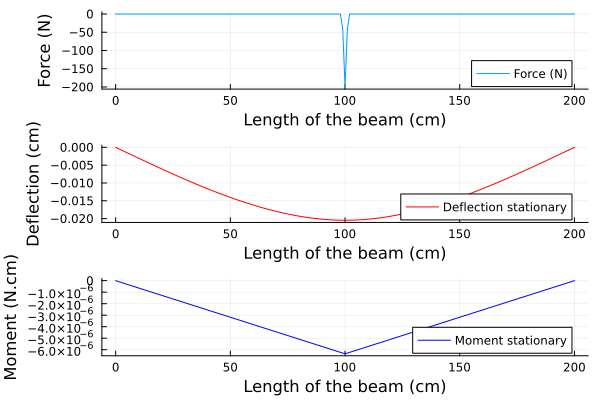

In [301]:
N = 200
l = 200.
xvec = Vector(0:dx:l)
fvec = source_function.(xvec)

p1 = plot(xvec, fvec, label = "Force (N)", xlabel = "Length of the beam (cm)" , ylabel = "Force (N)" )
p2 = plot(xvec, biharmonic_3(N)[1], label = "Deflection stationary", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, biharmonic_3(N)[2], label = "Moment stationary", xlabel = "Length of the beam (cm)", ylabel = "Moment (N.cm)", linecolor = :blue)


plot(p1, p2,p3,layout=(3,1))


#### C.2) BoundaryValueDiffEq Pkg

Same as before, for this  example, I need to find 4 boundarys conditions with F a point force on the beam execpt boundarys. 
$$ \frac{\partial^4{W}}{\partial{x}^4} = \frac{F}{EI} $$

$$
    W|_{x=0} = 0 
$$
$$
    \frac{\partial^2 W}{\partial x^2}|_{x=0} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
    W|_{x=L} = 0 
$$

In [302]:
# define diffusion equation 
function diffusion_example_3!(du, u, p, x)

    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0. + (1/p[1]) * source_function(x)
    
end

diffusion_example_3! (generic function with 1 method)

In [303]:
# define boundary conditions 
function boundaries_example_3!(residual, u, p, x)

    residual[1] = u[1][1]                                               #Deflection at the beginning 
    residual[2] = u[1][3]                                               #Bending moment at the beginning 
    residual[end-1] = u[end][3]                                         #Bending Moment at the end 
    residual[end] = u[end][1]                                           #Deflection at the end 


end

boundaries_example_3! (generic function with 1 method)

In [304]:
function set_boundarys_example_3(N)  
    # define spatial range 
        xspan = (0.0, 200.)
        l = 200.
        dx = l/N
        E = 1.9 * 10^7
        I = 117.8
        p = [E*I]; 
    
    
        
    #set the boundary value problem to solve
        bvp1 = BVProblem(diffusion_example_3!, boundaries_example_3!, [0., 0.,200.,200.], xspan,p)
        
    
    # set the boundary value problem  
        sol1 = solve(bvp1, GeneralMIRK4(), dt = dx)
        sol_deflection = zeros(length(sol1))
        sol_moment = zeros(length(sol1))
    
        for i in 1:length(sol1)
            sol_deflection[i] = sol1[i][1]  
            sol_moment[i] = sol1[i][3]
        end
        return  [ - sol_moment , sol_deflection]
    
        
    end

set_boundarys_example_3 (generic function with 1 method)

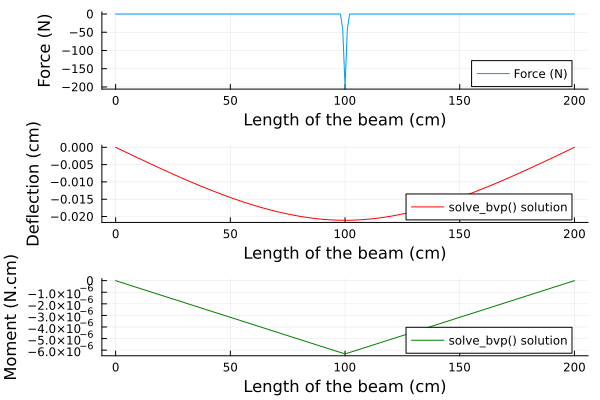

In [305]:
l =200.0
N = 200
dx = l/N
xvec = Vector(0:dx:l)
fvec = source_function.(xvec)

p1 = plot(xvec, fvec, label = "Force (N)", xlabel = "Length of the beam (cm)" , ylabel = "Force (N)" )
p2 = plot(xvec, set_boundarys_example_3(N)[2], label = "solve_bvp() solution", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, set_boundarys_example_3(N)[1], label = "solve_bvp() solution", xlabel = "Length of the beam (cm)", ylabel = "Moment (N.cm)", linecolor = :green)
plot(p1,p2,p3,layout=(3,1))

#### C.3) Comparison

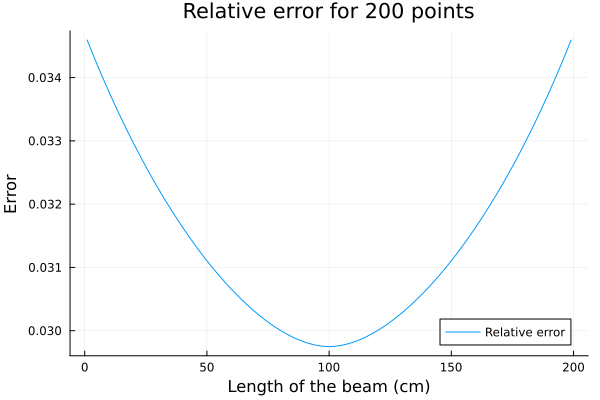

In [335]:
N = 200
exact = set_boundarys_example_3(N)[2]
modele = biharmonic_3(N)[1]
error = abs.((abs.(exact .- modele) ./ exact)) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam (cm)", ylabel = "Error", title = title)

### D) Simply supported beam with asymmetric load

For this  example, I need to find 4 boundarys conditions with F a point force on the beam execpt boundarys. 
$$ \frac{\partial^4{W}}{\partial{x}^4} = \frac{F}{EI} $$

$$
    W|_{x=0} = 0 
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
     W|_{x=L} = 0
$$

#### D.1) Finite Difference modeling 




I have to change the second and the penultimate lines of the matrix A again to fit the boundarys conditions. For this I discritized  for i in [1,N+1] points  : 
$$
    W_1 = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=0} = \frac{W_3 -2W_2 + W_1}{dx^2} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = \frac{W_{N+1} - 2W_{N} + W_{N-1}}{dx^2} = 0
$$
$$
    W_{N+1} = 0
$$

So, the matrix became : With $\alpha = \frac{EI}{dx^4}$


$$
A =  \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
\frac{1}{dx^2} & \frac{-2}{dx^2} & \frac{1}{dx^2}  & \dots & \dots & \dots & \dots & \dots & 0 \\
\alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 &\dots & \dots & 0 \\
0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  & 0 \\
 0 & \dots  & \dots  & 0 & \alpha  & -4\alpha  & 6\alpha  & -4\alpha  & \alpha  \\
 0&\dots & \dots & \dots & \dots  &  0 & \frac{1}{dx^2} & \frac{-2}{dx^2} & \frac{1}{dx^2}\\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\

\end{bmatrix}
$$


In [307]:
function source_function_4(x)
    X0 = 130.0
    σ = 0.8
    A = 200.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

source_function_4 (generic function with 1 method)

In [308]:
function matrix_deflection_4(n)
    #Parameter
        l = 200.#length 
        dx = l/n
        E = 1.9 * 10^7
        I = 117.8
        α = E * I / dx^4
    
        
    
    # Build the matrix
        A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )
    
    # Coefficient that change in the  matrix 
        A[1,2] = 0
        A[1,1]= 1
        A[1,3] = 0
        A[2,1] = 1
        A[2,2] = -2
        A[2,3] = 1
        A[2,4] = 0
        A[n-1, n-3] = 0
        A[n-1,n-2] = 1
        A[n-1,n-1] = -2
        A[n-1,n] = 1
        A[n,n-2] = 0
        A[n,n-1] = 0
        A[n,n]= 1
    
    #time 135.690 microseconds and 65 allocations for n= 2000
        return A
    end

matrix_deflection_4 (generic function with 1 method)

In [309]:
function matrix_bending_4(n)
    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8
    α = E * I / dx^2

    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 

    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
    
end

matrix_bending_4 (generic function with 1 method)

In [310]:
function biharmonic_4(N)
    #Parameter of the beam
        l= 200. #length
        dx = l/ N  

    # Build of the matrix A
        A = matrix_deflection_4(N+1)
        M1 = matrix_bending_4(N)

    # Vector B and M1
        b = zeros(N+1)
        b[1] = 0                                        #encastrement 
        b[2] = 0                                        #Benging Moment
        b[end-1] = 0                                    #bending Moment
        b[end] = 0                                      #encastrement

        b2 = zeros(N+1)
        b2[1] = 0
        b2[end] = 0

    # Vector S for the source power
        X_vect = Vector(0:dx:l)
        S = source_function_4.(X_vect) 

    # Solving of the Linear System
        u = A \ (b+S) 
        m = M1 \ (b2+S) 
        return [u,m]
end

biharmonic_4 (generic function with 1 method)

In [311]:
@btime biharmonic_4(1000)

  1.324 ms (279 allocations: 2.92 MiB)


2-element Vector{Vector{Float64}}:
 [0.0, -5.145019138643393e-5, -0.00010290038277286787, -0.00015435022110643837, -0.00020579935333428184, -0.00025724742640353466, -0.0003086940872613331, -0.0003601389828548134, -0.0004115817601311116, -0.0004630220660373637  …  -0.0005658896515512269, -0.0005030252790129397, -0.0004401563106952087, -0.00037728340313795456, -0.0003144072128810981, -0.00025152839646455996, -0.00018864761042826066, -0.00012576551131212064, -6.288275565606032e-5, 0.0]
 [0.0, -8.869373266795445e-9, -1.7738746533749397e-8, -2.6608119801020365e-8, -3.547749306876686e-8, -4.434686633714739e-8, -5.3216239606320476e-8, -6.208561287644459e-8, -7.095498614767827e-8, -7.982435942018002e-8  …  -1.482453713913986e-7, -1.3177366345234852e-7, -1.153019555156534e-7, -9.88302475810189e-8, -8.235853964815066e-8, -6.588683171675429e-8, -4.9415123786535405e-8, -3.294341585719965e-8, -1.6471707928452635e-8, 0.0]

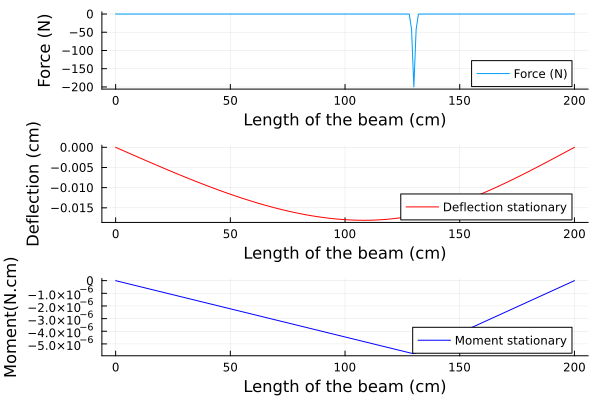

In [312]:

p1 = plot(xvec, source_function_4.(X), label = "Force (N)", xlabel = "Length of the beam (cm)", ylabel = "Force (N)" )
p2 = plot(xvec, biharmonic_4(N)[1], label = "Deflection stationary", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, biharmonic_4(N)[2], label = "Moment stationary", xlabel = "Length of the beam (cm)", ylabel = "Moment(N.cm)", linecolor = :blue)



plot(p1, p2,p3,layout=(3,1))

#### D.2) BoundaryValueDiffEq Pkg

In [313]:
# define diffusion equation 
function diffusion_example_4!(du, u, p, x)

    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0. + (1/p[1]) * source_function_4(x)
    
end

diffusion_example_4! (generic function with 1 method)

In [314]:
# define boundary conditions 
function boundaries_example_4!(residual, u, p, x)

    residual[1] = u[1][1]                                              # Deflection at the beginning 
    residual[2] = u[1][3]                                              # Bending moment at the beginning 
    residual[end-1] = u[end][3]                                        # Bending Moment at the end 
    residual[end] = u[end][1]                                          # Deflection at the end 


end

boundaries_example_4! (generic function with 1 method)

In [315]:
function set_boundarys_example_4(N)  
    # define spatial range 
        xspan = (0.0, 200.)
        l = 200.
        dx = l/N
        E = 1.9 * 10^7
        I = 117.8
        p = [E*I]; 
    
    
        
    #set the boundary value problem to solve
        bvp1 = BVProblem(diffusion_example_4!, boundaries_example_4!, [0., 0.,0.,0.], xspan,p)
    
    # set the boundary value problem  
        sol1 = solve(bvp1, GeneralMIRK4(), dt = dx)
        sol_deflection = zeros(length(sol1))
        sol_moment = zeros(length(sol1))
    
        for i in 1:length(sol1)
            sol_deflection[i] = sol1[i][1]  
            sol_moment[i] = sol1[i][3]
        end
        return  [ - sol_moment , sol_deflection]
        
        
        
    end

set_boundarys_example_4 (generic function with 1 method)

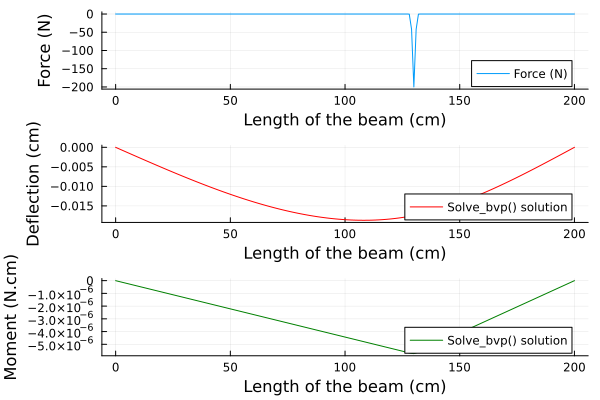

In [316]:
l =200.
N = 200
dx = l/N
xvec = Vector(0:dx:l)
fvec = source_function_4.(xvec)

p1 = plot(xvec,fvec,label = "Force (N)",xlabel = "Length of the beam (cm)", ylabel = "Force (N)")
p2 = plot(xvec, set_boundarys_example_4(N)[2], label = "Solve_bvp() solution", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, set_boundarys_example_4(N)[1], label = "Solve_bvp() solution", xlabel = "Length of the beam (cm)", ylabel = "Moment (N.cm)", linecolor = :green)

plot(p1, p2,p3,layout=(3,1))

#### D.3) Comparison

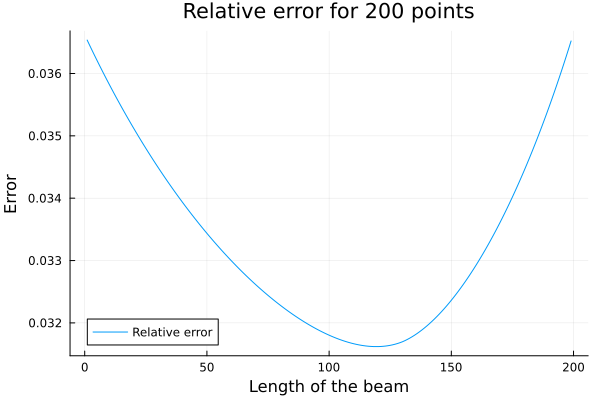

In [336]:
exact = set_boundarys_example_4(N)[2]
modele = biharmonic_4(N)[1]
error = abs.((abs.(exact .- modele) ./ exact)) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam", ylabel = "Error", title = title)

### E) Statically indeterminate beams

The bending moments and shear forces in Euler–Bernoulli beams can often be determined directly using static balance of forces and moments. However, for certain boundary conditions, the number of reactions can exceed the number of independent equilibrium equations.Such beams are called statically indeterminate.

To determine the stresses and deflections of such beams, the most direct method is to solve the Euler–Bernoulli beam equation with appropriate boundary conditions. But direct analytical solutions of the beam equation are possible only for the simplest cases. Therefore, additional techniques such as linear superposition are often used to solve statically indeterminate beam problems.

The superposition method involves adding the solutions of a number of statically determinate problems which are chosen such that the boundary conditions for the sum of the individual problems add up to those of the original problem.

I choose theses boundarys conditions to solve the problem : 

$$ \frac{\partial^4{W}}{\partial{x}^4} = \frac{F}{EI}$$ 

$$
    W|_{x=0} = 0 
$$
$$
    \frac{\partial W}{\partial x}|_{x=0} = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
    W|_{x=L} = 0
$$

#### E.1) Finite Difference method 




I have to change the second and the penultimate lines of the matrix A again to fit the boundarys conditions. For this I discritized  for i in [1,N+1] points  : 
$$
    W_1 = 0
$$
$$
    \frac{\partial  W}{\partial x}|_{x=0} = \frac{W_2 - W_1}{dx} = 0 \Rightarrow W_2 = W_1 = 0
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = \frac{W_{N+1} - 2W_{N} + W_{N-1}}{dx^2} = 0
$$
$$
    W_{N+1} = 0
$$

So, the matrix became : 


With $\alpha = \frac{EI}{dx^4} $
$$
A = \begin{bmatrix}
1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
\frac{-1}{dx} & \frac{1}{dx} & 0 & \dots & \dots & \dots & \dots & \dots & 0 \\
\alpha  & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 &\dots & \dots & 0 \\
0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 & \dots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0  & \dots  & 0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha & 0 \\
 0 & \dots  & \dots  & 0 & \alpha & -4\alpha & 6\alpha & -4\alpha & \alpha \\
0&\dots & \dots & \dots & \dots & 0 & \frac{1}{dx^2}  & \frac{-2}{dx^2} & \frac{1}{dx^2} \\
0&\dots & \dots & \dots & \dots & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

In [343]:
function source_function_5(x)
    X0 = 130.0
    A = 200
    l =200.
    return  ((5*l*A) / (8*X0)) * x - ((5*l*A) / 8)
end

source_function_5 (generic function with 1 method)

In [344]:
function matrix_deflection_5(n)
    #Parameter
    l = 200.#length 
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8 
    α = E * I / dx^4
    x = Vector(0:dx:l)

       

# Build the matrix
    A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )

# Coefficient that change in the  matrix (TRIED SOMETHING THAT WORK BETTER)
    A[1,2] = 0
    A[1,1]= 1
    A[1,3] = 0

    A[2,1] = -1 /dx
    A[2,2] = 1 /dx 

    A[2,3] = 0
    A[2,4] = 0

   A[n-1,n-4] = 0
    A[n-1,n-3] = 0
    A[n-1,n-2] = 1 /dx^2
    A[n-1,n-1] = -2/dx^2
    A[n-1,n]=  1/dx^2

    
    A[n,n-2] = 0
    A[n,n-1] = 0
    A[n,n] = 1





#time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

matrix_deflection_5 (generic function with 1 method)

In [345]:
function matrix_bending_5(n)
    l = 200.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8
    α = E * I / dx^2

    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 

    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
    
end

matrix_bending_5 (generic function with 1 method)

In [346]:
function biharmonic_5(N)
#Parameter of the beam
    l= 200 #length
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8
    X_vect = Vector(0:dx:l)

# Build of the matrix A and M1
    A = matrix_deflection_5(N+1)
    M1 = matrix_bending_5(N)

# Vector B fand b2
    b = zeros(N+1)
    b[1] = 0 
    b[2] = 0    
    b[end-1] = 0 
    b[end] =  0

    b2 = zeros(N+1)
    b2[1] = 0.0015
    b2[end] = 0

# Vector S for the source power        
    S = source_function_5.(X_vect) 
    
    S[1] = 0
    S[2] = 0
    S[end-1] = 0
    S[end] = 0    

# Solving of the Linear System
    u = A \ (S+b)
    m = M1 \ (S+b2)
    return [u,m]
end

biharmonic_5 (generic function with 1 method)

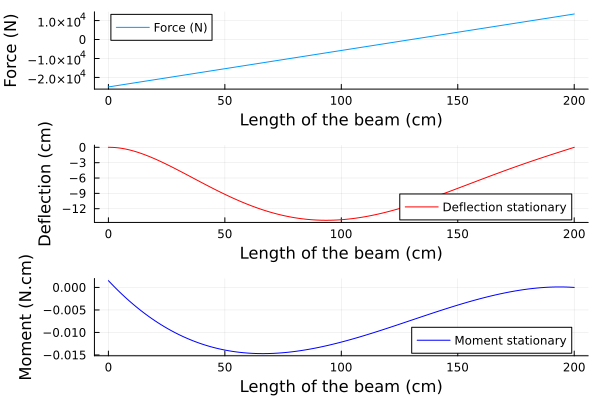

In [347]:
l =200.
N = 200
dx = l/N
xvec = Vector(0:dx:l)
fvec = source_function_5.(xvec)

p1 = plot(xvec,fvec,label = "Force (N)", xlabel = "Length of the beam (cm)", ylabel = "Force (N)")
p2 = plot(xvec, biharmonic_5(N)[1], label = "Deflection stationary", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, biharmonic_5(N)[2], label = "Moment stationary", xlabel = "Length of the beam (cm)", ylabel = "Moment (N.cm)", linecolor = :blue)


plot(p1, p2,p3,layout=(3,1))


#### E.2) BoundaryValueDiffEq Pkg

In [323]:
# define diffusion equation 
function diffusion_example_5!(du, u, p, x)
    
    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = 0. + source_function_5(x) /p[1]

end

diffusion_example_5! (generic function with 1 method)

In [324]:
# define boundary conditions 
function boundaries_example_5!(residual, u, p, x)

    residual[1] = u[1][1]                                              # Deflection at the beginning 
    residual[2] = u[2][1]                                              # Slope at the beginning W2=W1=0
    residual[end] = u[end][3]                                          # Bending Moment at the end 
    residual[end-1] = u[end][1]                                        # Deflection at the end 
end


boundaries_example_5! (generic function with 1 method)

In [325]:
function set_boundarys_example_5(N)  
    # define spatial range 
        xspan = (0.0, 200.)
        E = 1.9 * 10^7
        I = 117.8
        p = [E*I];
        l = 200.
        dx = l/N 
    
    
        
    #set the boundary value problem to solve
        bvp1 = BVProblem(diffusion_example_5!, boundaries_example_5!, [0., 0.,200.,200.], xspan,p)
    
    # set the boundary value problem  
        sol1 = solve(bvp1, GeneralMIRK4(), dt = dx)
        sol_deflection_1 = zeros(length(sol1))
        sol_moment_1 = zeros(length(sol1))
    
        for i in 1:length(sol1)
            sol_deflection_1[i] = sol1[i][1]  
            sol_moment_1[i] = sol1[i][3]
        end
        return  [ - sol_moment_1 , sol_deflection_1]
    
        
    end

set_boundarys_example_5 (generic function with 1 method)

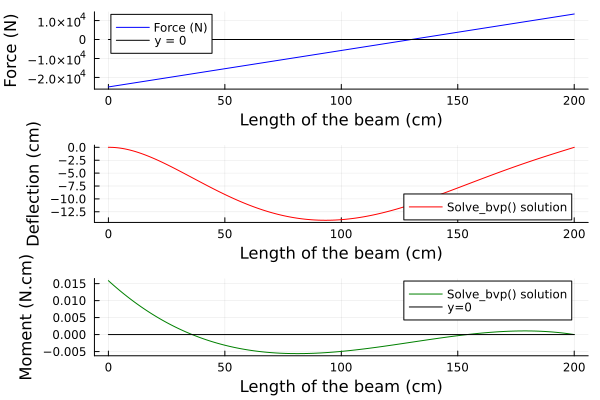

In [326]:
N = 200
l =200.
dx = l/N
xvec = Vector(0:dx:l) 
y = zeros(length(xvec))

p1 = plot(xvec, [source_function_5.(xvec),y], label = ["Force (N)" "y = 0"], xlabel = "Length of the beam (cm)" ,ylabel = "Force (N)", linecolor = [:blue :black])
p2 = plot(xvec, set_boundarys_example_5(N)[2],  label = "Solve_bvp() solution", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)
p3 = plot(xvec, [set_boundarys_example_5(N)[1], y], label = ["Solve_bvp() solution" "y=0"], xlabel = "Length of the beam (cm)", ylabel = "Moment (N.cm)", linecolor = [:green :black])

plot(p1,p2,p3,layout=(3,1))

#### E.3) Comparison 

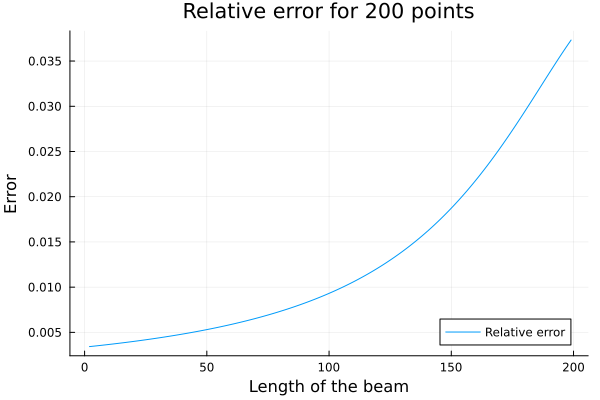

In [337]:
exact = set_boundarys_example_5(N)[2]
modele = biharmonic_5(N)[1]
error = abs.((abs.(exact .- modele) ./ exact)) 
title = "Relative error for $N points"
plot(xvec, error, label = "Relative error", xlabel = "Length of the beam", ylabel = "Error", title = title)

### 7)  Best example to solve the case of the bus door

The aim is to participate in the development of numerical tools for the simulation of vibrating doors in touring buses. To model the bus door, I chose a 200 cm steel beam. A bus door is a mixture of glass and steel, but for this part, the door is hit with a hammer and the glass would have shattered, so the modeling would have been useless.

As I said above, I took the liberty of using a hammer to deform the beam, to find the force required the formula is $F = m \times a = 200 N$ with m the mass of the hammer and a the acceleration of the hammer blow. 
Once the force has been determined, we need to find the best boundary conditions for modeling. The beam will be held in place by 2 springs at the ends, and after some research I realized that there is no bending moment with the springs stressed, so the first two boundary conditions are :

$$
    \frac{\partial^2 W}{\partial x ^2}|_{x=0} = 0 
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$

Also, there's no embedded part on the beam, so there's no slope at the ends, so I can't use the first derivative for my boundary conditions. 
When stationary, the springs will add a force at the ends of the beam opposite the source, but these two forces will not be constant because of the springs. Initially, I can use these conditions as boundary conditions.

$$
    \frac{\partial^3 W}{\partial x^3}|_{x=0} = ?
$$
$$
    \frac{\partial^3 W}{\partial x^3}|_{x=L} = ?

$$

In this part, I model the stationary biharmonic equation, so that the springs can be used as two constant forces because the springs will be in their equilibrium position. So I need to find springs that I can use for modeling, then determine their equilibrium position to find the force at the ends. For this job, I'll be using a 302 stainless steel springs with a diameter of 3 cm, a maximum load length of 2.7 cm, a maximum load of 1,300 N and a spring stiffness of 97 N/mm.

To determine the force of the spring in its equilibrium position, I'll use the fundamental principles of statics : 

$$
F_{spring 1} = F_{spring 2} = - \frac{F_{source}}{2} = 100  \space N
$$

Moreover, the maximum load length of the spring is 2.7 cm for 1300 N. It can be possible to use the length of the springs with the charge, in this case the stationnary lentgth of the springs is 10 cm.

So the boundarys conditions are : 

$$
    \frac{\partial^2 W}{\partial x ^2}|_{x=0} = 0 
$$
$$
    \frac{\partial ^2 W}{\partial x^2}|_{x=L} = 0
$$
$$
    W|_{x=0} = -10
$$
$$
    W|_{x=L} = -10

$$

Another possibility is to determine the equilibrium length of the spring, in order to complete the edge conditions on the beam displacements :  

In [4]:
function source_function_6(x)
    X0 = 100.0
    σ = 0.8
    A = 200.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

source_function_6 (generic function with 1 method)

In [5]:
function matrix_6(n)
    #Parameter
    l = 200.#length 
    dx = l/N
    E = 1.9 * 10^7
    I = 117.8 
    α = E * I / dx^4
    x = Vector(0:dx:l)

       

# Build the matrix
    A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )

# Coefficient that change in the  matrix (TRIED SOMETHING THAT WORK BETTER)

    
    A[1,2] = 0
    A[1,1]= 1
    A[1,3] = 0

    A[2,1] = 1/dx^2
    A[2,2] = -2/dx^2
    A[2,3] = 1/dx^2
    A[2,4] = 0

    A[n-1, n-3] = 0
    A[n-1,n-2] = 1/dx^2
    A[n-1,n-1] = -2/dx^2
    A[n-1,n] = 1/dx^2


    A[n,n-2] = 0
    A[n,n-1] = 0
    A[n,n]= 1




#time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

matrix_6 (generic function with 1 method)

In [6]:
function biharmonic_6(N)
    #Parameter of the beam
        l= 200 #length
        dx = l/N
        E = 1.9 * 10^7
        I = 117.8
        X_vect = Vector(0:dx:l)
    
    # Build of the matrix A
        A = matrix_6(N+1)
    
    # Vector B from Au = B (Boundary)
        b = zeros(N+1)
        b[1] = - 2
        b[2] =  0
        b[end-1] = 0
        b[end] =  -2
    
    # Vector S for the source power        
        S = source_function_6.(X_vect) 
        S[1] = 0
        S[2] = 0
        S[end-1] = 0
        S[end] = 0
    
    # Solving of the Linear System
        u = A \ (S+b)
        return u
    end

biharmonic_6 (generic function with 1 method)

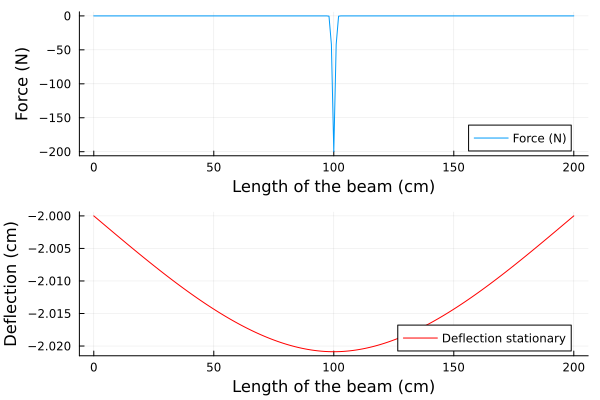

In [7]:
l =200.
N = 200

dx = l/N
xvec = Vector(0:dx:l)
fvec = source_function_6.(xvec)

p1 = plot(xvec,fvec,label = "Force (N)", xlabel = "Length of the beam (cm)", ylabel = "Force (N)")
p2 = plot(xvec, biharmonic_6(N), label = "Deflection stationary", xlabel = "Length of the beam (cm)", ylabel = "Deflection (cm)", linecolor = :red)

plot(p1, p2,layout=(2,1))


### 8) Spectral Analysis of the coeffcient matrix 

Here I compute eigenvalues and eigenvectors of the matrix A. 

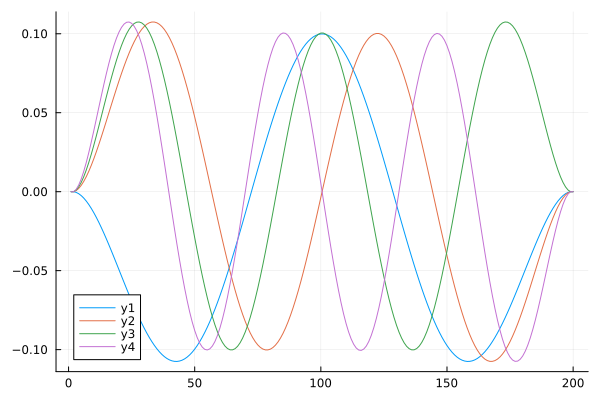

In [21]:
matrix = matrix_6(N)
F = eigen(Matrix(matrix)) 
plot(F.vectors[:,7:10]) 